[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Shmoo137/ML-Tutorials/blob/main/Explaining_with_CAM.ipynb)
# **Interpretability methods for neural networks**

## Why do we bother with interpretability at all?

* making the model more reliable -> when we analyze what features are the most important for the model during classification, and we find out the model looks at something irrelevant to the human, we can fight it and make the model more reliable. E.g.: **[picture](http://3.bp.blogspot.com/-S8g8SNWhyR0/WIsOFqPD2WI/AAAAAAAAA68/9yNFp6sdao0Er7qDIqEPu7ORTU589tFCACK4B/s1600/Bildschirmfoto%2B2017-01-27%2Bum%2B10.08.11.png): husky on the snow => prediction: wolf**


* ethical reasons: preventing biases inherited from humans and increasing trust in models applied in real-life problems, e.g., helping in medial diagnosis
* legal reasons: since May 2019 every EU citizen has the right to know the reasoning process behind every automated decision that concerns him/her
* the only way for ML to teach us something new about physics?

There are ML models that are inherently interpretable (up to some complexity degree), like decision trees or linear models.

The most common example of a complex uninterpretable ML model are deep neural networks (including convolutional neural networks, being especially useful in image classification).

## What methods are there?

Their number is huge and growing fast. Some of the interpretability methods can be found in packages like [iNNvestigate](https://github.com/albermax/innvestigate/blob/master/examples/notebooks/mnist_compare_methods.ipynb), [InterpretML](https://arxiv.org/abs/1909.09223) or [Alibi](https://github.com/SeldonIO/alibi).


## What will we do today?

We will implement the Class Activation Maps (CAM) [(original paper)](https://arxiv.org/pdf/1512.04150.pdf). They have many extensions (e.g., [Grad-CAM](https://jacobgil.github.io/deeplearning/class-activation-maps)).

# Class Activation Maps (CAM)

Code based on [the code provided by the method's authors](https://github.com/zhoubolei/CAM).

![CAM](https://drive.google.com/uc?id=1vibsld9iq7j4GYgDP5LMXdoitvfr8q_M)

## We'll start from importing a ready-to-use neural network **with GAP in the end**

We will use CAMs to explain predictions of ResNet on images from the dataset ImageNet. It is a collection of over 14 millions photos belonging to [1000](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) categories (to be exact, 1000 non-overlapping categories, in general 20 000 classes are listed there, but NNs race on the dataset with separable classes).

Designing and training from scratch an accurate NN recognizing such a number of objects would be tough and time-consuming so let's stand on the arms of the giants, and import a NN that is ready-to-use! :)

In [1]:
import io
import requests
from PIL import Image
from google.colab.patches import cv2_imshow # for image display

from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pdb

In [2]:
# Let's decide on the model first. Maybe print it out so we see the architecture.
# Remember, for the basic CAM, the global average pooling (GAP) is needed! Every feature map has to have only one value in the fully-connected layer!
# networks such as GoogleNet, ResNet, DenseNet already use global average pooling at the end, so CAM could be used directly.
# You can look at them here: https://neurohive.io/en/popular-networks/
model_id = 2 # 1 = SqueezeNet, 2 = ResNet18, 3 = DenseNet161

if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

#print(net)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Now let's take exemplary images.
And let's make some predictions! To make predictions, we need to download the list of 1000 categories used by the pre-trained models. Why? Because when making predictions, the model will only tell us the number of the class. We need to find its name.

### Let's start with loading all class names

In [3]:
# Download the imagenet category list:
LABELS_URL = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
classes = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [4]:
# Print them. They don't look too nice, let's leave only names!
print(classes)

{0: ['n01440764', 'tench'], 1: ['n01443537', 'goldfish'], 2: ['n01484850', 'great_white_shark'], 3: ['n01491361', 'tiger_shark'], 4: ['n01494475', 'hammerhead'], 5: ['n01496331', 'electric_ray'], 6: ['n01498041', 'stingray'], 7: ['n01514668', 'cock'], 8: ['n01514859', 'hen'], 9: ['n01518878', 'ostrich'], 10: ['n01530575', 'brambling'], 11: ['n01531178', 'goldfinch'], 12: ['n01532829', 'house_finch'], 13: ['n01534433', 'junco'], 14: ['n01537544', 'indigo_bunting'], 15: ['n01558993', 'robin'], 16: ['n01560419', 'bulbul'], 17: ['n01580077', 'jay'], 18: ['n01582220', 'magpie'], 19: ['n01592084', 'chickadee'], 20: ['n01601694', 'water_ouzel'], 21: ['n01608432', 'kite'], 22: ['n01614925', 'bald_eagle'], 23: ['n01616318', 'vulture'], 24: ['n01622779', 'great_grey_owl'], 25: ['n01629819', 'European_fire_salamander'], 26: ['n01630670', 'common_newt'], 27: ['n01631663', 'eft'], 28: ['n01632458', 'spotted_salamander'], 29: ['n01632777', 'axolotl'], 30: ['n01641577', 'bullfrog'], 31: ['n01644373',

In [5]:
classes = [classes[i][1] for i in range(len(classes))]

In [6]:
# Clean classes for our use!
classes[:10]

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

### Time for some images!

In [7]:
# List of images to classify
# you can play with it, just be careful with putting large images. Too large sizes will give you errors like "I don't recognize this object"
images = [
          ('cat', 'https://www.lismore.nsw.gov.au/files/assets/public/v/1/1.-households/4.-pets-amp-animals/images/kitten.jpg?dimension=pageimage&w=480'),
          ('dog', 'https://post.healthline.com/wp-content/uploads/2020/08/3180-Pug_green_grass-732x549-thumbnail-732x549.jpg'),
          ('wine', 'https://www.thetimes.co.uk/imageserver/image/methode%2Fsundaytimes%2Fprod%2Fweb%2Fbin%2F5e7dc0d2-9b24-11e8-9837-8c5d4fba4ce3.jpg?crop=2667%2C1500%2C0%2C0&resize=685')
         ]

In [8]:
# To classify an arbitrary image, we need to do some preprocessing to it before inputting to the model.
# Namely: (1) Resize to (224, 224) so it fits the input size of our network.
# (2) Transform the data into the format called "Tensor" which is used by PyTorch.
# (3) Normalize the image accordingly to the mean and standard deviation of the training data in ImageNet dataset .

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize])

In [9]:
# Set the model into evaluation mode
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

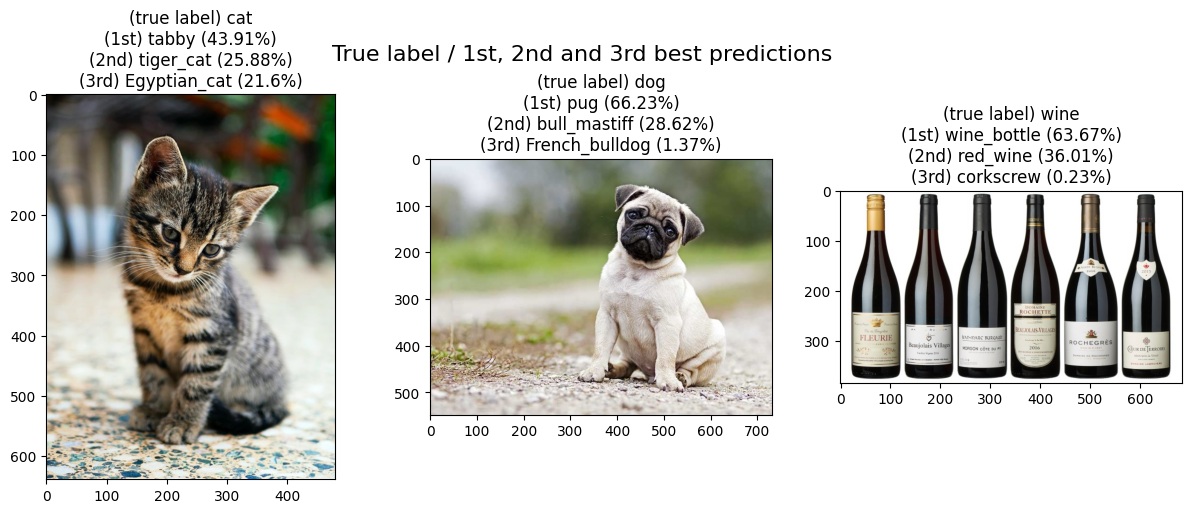

In [10]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
fig.suptitle('True label / 1st, 2nd and 3rd best predictions', fontsize=16)

for i, image in enumerate(images):

    # Get image
    class_name, img_url = image[0], image[1]
    response = requests.get(img_url)
    img_pil = Image.open(io.BytesIO(response.content))

    # We preprocess it
    img_tensor = preprocess(img_pil)
    img_variable = Variable(img_tensor.unsqueeze(0))

    # Get predictions for all classes
    preds = F.softmax(net(img_variable), dim=1).data.squeeze()

    # Sort predictions
    preds_sorted, idxs = preds.sort(descending=True)

    # Get best 3 predictions - classes
    pred_1_class = classes[idxs[0]]
    pred_2_class = classes[idxs[1]]
    pred_3_class = classes[idxs[2]]

    # Get best 3 predictions - probabilities
    pred_1_prob = np.round(100*preds_sorted[0].item(),2)
    pred_2_prob = np.round(100*preds_sorted[1].item(),2)
    pred_3_prob = np.round(100*preds_sorted[2].item(),2)
    preds_best3 = [f'{pred_1_class} ({pred_1_prob}%)', f'{pred_2_class} ({pred_2_prob}%)', f'{pred_3_class} ({pred_3_prob}%)']

    # Display images with True label / 1st, 2nd and 3rd best Predictions
    ax[i].imshow(img_pil)
    ax[i].set_title(f'(true label) {class_name}\n(1st) {preds_best3[0]}\n(2nd) {preds_best3[1]}\n(3rd) {preds_best3[2]}')

### Let's focus now on a single image and single prediction. How to interpret it?
We know how to make predictions with ResNet which can classify objects on images into 1000 classes. Let's implement CAM and make ResNet tell us what it looks at, when thinking of each class.

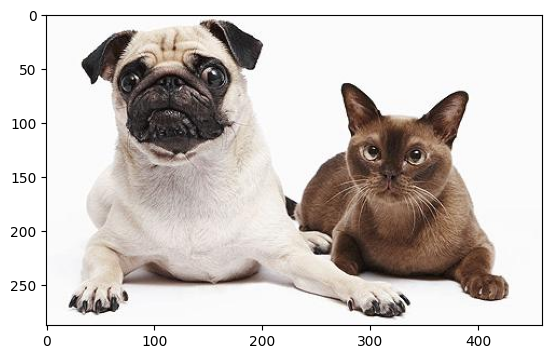

In [11]:
# input image
IMG_URL = 'https://cdn.shopify.com/s/files/1/0220/2378/files/Natura_Petz_supplements_for_endocrine_support_in_dogs_and_cats._5e6f2548-2af1-4724-b21f-02775298f5a1_large.jpg?15129879335162912830'#'https://www.oldtownmanor.com/wp-content/uploads/2015/01/Purebred-Breeders-LLC-Dog-Friendly-Airline.jpg'

# print the input image
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
plt.imshow(img_pil)

In [12]:
# If you want to save your results, you need to mount the Google drive
"""
from google.colab import drive
drive.mount('/content/drive/')
folder = '/content/drive/My Drive/Colab Notebooks/'

#response = requests.get(IMG_URL)
#img_pil = Image.open(io.BytesIO(response.content))
img_pil.save(folder + 'test.jpg')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive/')\nfolder = '/content/drive/My Drive/Colab Notebooks/'\n\n#response = requests.get(IMG_URL)\n#img_pil = Image.open(io.BytesIO(response.content))\nimg_pil.save(folder + 'test.jpg')\n"

In [13]:
# Hook the feature extractor. It means that now will be following what gets activated in the last convolutional layer.
# So when we finally make a prediction on the test image with our model, this hook will contain the activated features.
# The name of the last convolutional layer depend on the model we chose. In the cell where we did that, we also defined 'finalconv_name'.
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [14]:
# Get the softmax weight (on the side of GAP, therefore 'params[-2]', so second from the end), so we take these single values to which every feature maps collapsed when we applied GAP.
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

In [15]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [16]:
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))

# Finally, the prediction! Hook attached to the final convolutional layer will remember the activated features.
logit = net(img_variable)

In [17]:
# We put the logit through the softmax:
h_x = F.softmax(logit, dim=1).data.squeeze()

# We sort the probabilities along with the corresponding labels
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# Output the prediction (so here 5 labels with the highest probabilities)
for i in range(0, 10):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.433 -> pug
0.359 -> Siamese_cat
0.088 -> French_bulldog
0.086 -> Brabancon_griffon
0.016 -> Boston_bull
0.004 -> Chihuahua
0.002 -> bull_mastiff
0.001 -> muzzle
0.001 -> malinois
0.001 -> tennis_ball


In [18]:
# Finally, we can generate class activation mapping for the any class prediction.
# Let's start with the class with the highest probability, so top1: idx[0] (we sorted it accordingly to the probabilities, remmember?)
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

output CAM.jpg for the top1 prediction: pug
(288, 460, 3)


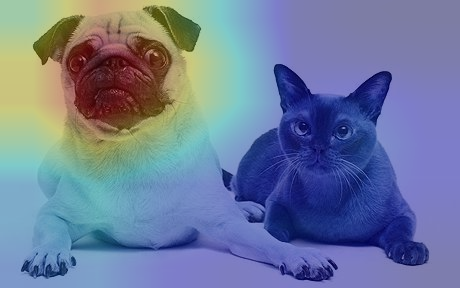

In [19]:
# Render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
#img = cv2.imread(folder + 'test.jpg') # if you mounted the Google drive, otherwise below
img = np.array(img_pil)
print(img.shape)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
#cv2.imwrite(folder + 'CAM.jpg', result) # if you mounted the Google drive
cv2_imshow(result) # Colab and cv2.imshow() don't work, that's why we imported a patch with cv2_imshow

output CAM.jpg for the top2 prediction: Siamese_cat
(288, 460, 3)


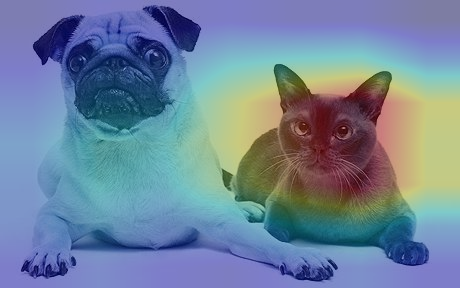

In [20]:
# Render the CAM and output
which_prediction = 1
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[which_prediction]])
print('output CAM.jpg for the top2 prediction: %s'%classes[idx[which_prediction]])
#img = cv2.imread(folder + 'test.jpg') # if you mounted the Google drive, otherwise below
img = np.array(img_pil)
print(img.shape)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
#cv2.imwrite(folder + 'CAM.jpg', result) # if you mounted the Google drive
cv2_imshow(result) # Colab and cv2.imshow() don't work, that's why we imported a patch with cv2_imshow

# To do:

1. Follow the shapes of:
*   the input image
*   the output of the model
*   the size of the last layer (after GAP)
*   what CAM function exactly does? What is 'weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))', why then the result is reshaped to (h, w)? What are 'bz, nc, h, w'? Print them out.
*   what cv2.resize does? Why is it needed?
2. Apply this method to a few images and consider what one can learn from CAMs and what are their limitations.
3. Apply this method to a few images of the same category (e.g., various dogs, various cats) and again consider what one can learn from CAMs.


